# Music generation with LSTM

The following tutorial has been used in development: https://www.tensorflow.org/tutorials/audio/music_generation

## Imports

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6 MB 5.3 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=966597cd124ea66f5f3b98e07f124807e3b8b4a1c251e2e357f8656135fba6ed
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import tensorflow as tf
from IPython import display
import pretty_midi

from matplotlib import pyplot as plt
import seaborn as sns

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Work with Midi

In [ ]:
data_dir = pathlib.Path('drive/MyDrive/music_generation_data/maestro-v2.0.0')

sample_file = glob.glob(str(data_dir/'**/*.mid*'))[1]
filenames = glob.glob(str(data_dir/'**/*.mid*'))

print(sample_file)

drive/MyDrive/music_generation_data/maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--4.midi


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
file_1 = pretty_midi.PrettyMIDI(sample_file)

display_audio(file_1)

In [ ]:
print('Number of instruments:', len(file_1.instruments))
instrument_name = pretty_midi.program_to_instrument_name(file_1.instruments[0].program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Work with raw notes

In [ ]:
instrument = file_1.instruments[0]

for i, note in enumerate(instrument.notes[:15]):
  print(f'{i}: pitch={note.pitch}, note_name={pretty_midi.note_number_to_name(note.pitch)},'
        f' duration={note.end - note.start:.4f}')

0: pitch=57, note_name=A3, duration=0.9102
1: pitch=62, note_name=D4, duration=0.5638
2: pitch=69, note_name=A4, duration=0.4688
3: pitch=62, note_name=D4, duration=0.3971
4: pitch=57, note_name=A3, duration=0.3477
5: pitch=54, note_name=F#3, duration=0.0807
6: pitch=45, note_name=A2, duration=0.0964
7: pitch=62, note_name=D4, duration=0.0742
8: pitch=38, note_name=D2, duration=0.1771
9: pitch=57, note_name=A3, duration=0.6719
10: pitch=62, note_name=D4, duration=0.2982
11: pitch=69, note_name=A4, duration=0.4622
12: pitch=62, note_name=D4, duration=0.3815
13: pitch=57, note_name=A3, duration=0.2773
14: pitch=54, note_name=F#3, duration=0.0573


In [ ]:
def midi_to_notes(files: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(files)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)
  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start
  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start
  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


raw_notes = midi_to_notes(sample_file)
raw_notes.head(10)

,pitch,start,end,step,duration
0,57,1.009115,1.919271,0.000000,0.910156
1,62,1.483073,2.046875,0.473958,0.563802
2,69,1.916667,2.385417,0.433594,0.468750
3,62,2.299479,2.696615,0.382812,0.397135
4,57,2.625000,2.972656,0.325521,0.347656
5,54,3.009115,3.089844,0.384115,0.080729
6,45,3.385417,3.481771,0.376302,0.096354
7,62,3.730469,3.804688,0.345052,0.074219
8,38,4.179688,4.356771,0.449219,0.177083
9,57,4.726562,5.398438,0.546875,0.671875


In [ ]:
all_notes = []
for f in filenames[:5]:
  notes = midi_to_notes(f)
  all_notes.append(notes)
notes_df = pd.concat(all_notes)

notes_numb = len(notes_df)
print(notes_df)
print(notes_numb)

      pitch        start          end      step  duration
0        74     1.023438     1.085938  0.000000  0.062500
1        81     1.545573     2.598958  0.522135  1.053385
2        57     2.031250     2.095052  0.485677  0.063802
3        62     2.533854     2.576823  0.502604  0.042969
4        78     3.015625     3.529948  0.481771  0.514323
...     ...          ...          ...       ...       ...
8539     26  1275.545573  1278.583333  0.001302  3.037760
8540     62  1275.546875  1278.546875  0.001302  3.000000
8541     50  1275.549479  1278.575521  0.002604  3.026042
8542     54  1275.552083  1278.579427  0.002604  3.027344
8543     57  1275.558594  1278.575521  0.006510  3.016927

[19762 rows x 5 columns]
19762


In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

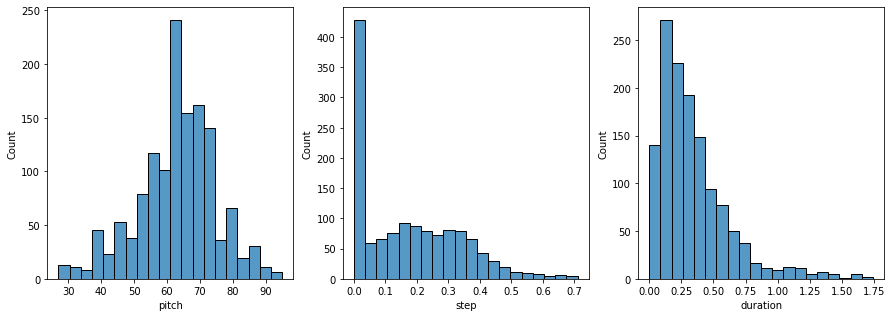

In [ ]:
plot_distributions(raw_notes)

## Forming train dataset

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([notes_df[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Each example will consist of a sequence of notes as the input features, and next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram explaining this process (and more details)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25 # Can be tuned  
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.578125   0.         0.0625    ]
 [0.6328125  0.52213542 1.05338542]
 [0.4453125  0.48567708 0.06380208]
 [0.484375   0.50260417 0.04296875]
 [0.609375   0.48177083 0.51432292]
 [0.578125   0.00911458 0.44661458]
 [0.5703125  0.49348958 0.04427083]
 [0.59375    0.00911458 0.04947917]
 [0.5546875  0.13411458 0.0390625 ]
 [0.578125   0.00520833 0.04817708]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=74.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.009114583333333037>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.04427083333333304>}


In [ ]:
batch_size = 64
buffer_size = notes_numb - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Modeling

In [ ]:
def mse(y_true: tf.Tensor, y_pred: tf.Tensor):
  mser = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mser + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse,
      'duration': mse,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

308/308 [==============================] - 9s 19ms/step - loss: 6.1570 - duration_loss: 1.1956 - pitch_loss: 4.8490 - step_loss: 0.1125


{'duration_loss': 1.195556879043579,
 'loss': 6.15701150894165,
 'pitch_loss': 4.848984718322754,
 'step_loss': 0.11247167736291885}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

308/308 [==============================] - 7s 18ms/step - loss: 1.5505 - duration_loss: 1.1956 - pitch_loss: 4.8490 - step_loss: 0.1125


{'duration_loss': 1.195556879043579,
 'loss': 1.550478219985962,
 'pitch_loss': 4.848984718322754,
 'step_loss': 0.11247167736291885}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20
308/308 [==============================] - 18s 57ms/step - loss: 0.4334 - duration_loss: 0.1709 - pitch_loss: 3.9394 - step_loss: 0.0655
Epoch 2/20
308/308 [==============================] - 17s 56ms/step - loss: 0.4272 - duration_loss: 0.1682 - pitch_loss: 3.9030 - step_loss: 0.0638
Epoch 3/20
308/308 [==============================] - 15s 49ms/step - loss: 0.4241 - duration_loss: 0.1670 - pitch_loss: 3.8913 - step_loss: 0.0626
Epoch 4/20
308/308 [==============================] - 13s 43ms/step - loss: 0.4205 - duration_loss: 0.1651 - pitch_loss: 3.8790 - step_loss: 0.0615
Epoch 5/20
308/308 [==============================] - 12s 40ms/step - loss: 0.4175 - duration_loss: 0.1651 - pitch_loss: 3.8697 - step_loss: 0.0590
Epoch 6/20
308/308 [==============================] - 13s 42ms/step - loss: 0.4155 - duration_loss: 0.1630 - pitch_loss: 3.8614 - step_loss: 0.0595
Epoch 7/20
308/308 [==============================] - 12s 40ms/step - loss: 0.4117 - duration_loss: 0.1608 - pit

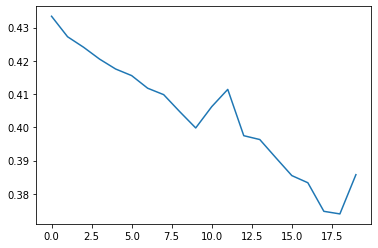

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Prediction

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,0.221501,0.645218,0.221501,0.866719
1,38,0.000000,0.606545,0.221501,0.828046
2,77,0.000000,0.618648,0.221501,0.840149
3,78,0.000000,0.663880,0.221501,0.885381
4,66,0.000000,0.667469,0.221501,0.888970
5,76,0.000000,0.669072,0.221501,0.890573
6,69,0.000000,0.684625,0.221501,0.906126
7,89,0.000000,0.695647,0.221501,0.917148
8,79,0.000000,0.727364,0.221501,0.948865
9,69,0.000000,0.754499,0.221501,0.976000


In [ ]:
def df_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:
  file = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))
  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start
  file.instruments.append(instrument)
  file.write(out_file)
  return file

generated = df_to_midi(raw_notes, out_file='generated.midi', instrument_name=instrument_name)

In [ ]:
display_audio(generated)